### Bitcoin Price Forecasting

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

### DATA LOADING AND EXPLORATION

In [2]:
df = pd.read_csv("dataset.csv", parse_dates=["Date"], index_col=["Date"])
prices = df["Closing Price (USD)"].values
timesteps = df.index.to_numpy()

print(f"Data shape: {prices.shape}")
print(f"Date range: {timesteps[0]} to {timesteps[-1]}")

Data shape: (2787,)
Date range: 2014-03-14T00:00:00.000000000 to 2021-10-29T00:00:00.000000000


In [3]:
def create_advanced_features(data, lags=[1, 2, 3, 7, 14, 30]):
    """Create multiple lagged features for better predictions."""
    df_features = pd.DataFrame(data, columns=['Price'])

    # Lagged features
    for lag in lags:
        df_features[f'Lag_{lag}'] = df_features['Price'].shift(lag)

    # Technical indicators
    df_features['Returns'] = df_features['Price'].pct_change()
    df_features['MA_7'] = df_features['Price'].rolling(7).mean()
    df_features['MA_14'] = df_features['Price'].rolling(14).mean()
    df_features['MA_30'] = df_features['Price'].rolling(30).mean()
    df_features['Volatility'] = df_features['Returns'].rolling(14).std()
    df_features['RSI'] = calculate_rsi(data, 14)

    # Momentum indicators
    df_features['Momentum'] = df_features['Price'].diff(14)
    df_features['Rate_of_Change'] = df_features['Price'].pct_change(14)

    # Trend
    df_features['Trend'] = (df_features['MA_7'] - df_features['MA_30']) / df_features['MA_30']

    return df_features.dropna()

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index indicator."""
    deltas = np.diff(prices)
    seed = deltas[:period+1]
    up = seed[seed >= 0].sum() / period
    down = -seed[seed < 0].sum() / period
    rs = up / down if down != 0 else 0
    rsi = np.zeros_like(prices)
    rsi[:period] = 100. - 100. / (1. + rs)

    for i in range(period, len(prices)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up / down if down != 0 else 0
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi
df_features = create_advanced_features(prices)
print(f"Features created: {df_features.shape[1]} features")

Features created: 16 features


In [4]:
X = df_features.drop('Price', axis=1).values
y = df_features['Price'].values

# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Train/test split (80/20)
split_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_size], X_scaled[split_size:]
y_train, y_test = y_scaled[:split_size], y_scaled[split_size:]
y_train_orig, y_test_orig = y[:split_size], y[split_size:]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (2205, 15)
Test set: (552, 15)


In [5]:
def evaluate_model(y_true, y_pred, model_name, y_true_orig=None):
    """Comprehensive model evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # MAPE on original scale
    if y_true_orig is not None:
        y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100
    else:
        mape = 0

    return {
        "Model": model_name,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }

In [6]:
print("  - Naive Baseline (previous day)")

naive_pred = y_test[:-1]
naive_results = evaluate_model(y_test[1:], naive_pred, "Naive", y_test_orig[1:])

  - Naive Baseline (previous day)


In [7]:
results = [naive_results]

# Ridge Regression (with proper hyperparameters)
print("  - Ridge Regression")
ridge = Ridge(alpha=10.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
results.append(evaluate_model(y_test, ridge_pred, "Ridge", y_test_orig))

# Random Forest (optimized)
print("  - Random Forest")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results.append(evaluate_model(y_test, rf_pred, "Random Forest", y_test_orig))

# Gradient Boosting (optimized)
print("  - Gradient Boosting")
gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    min_samples_split=5,
    random_state=42
)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
results.append(evaluate_model(y_test, gb_pred, "Gradient Boosting", y_test_orig))

  - Ridge Regression
  - Random Forest
  - Gradient Boosting


In [8]:
tf.random.set_seed(42)

model_dense = tf.keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="linear")
])

model_dense.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history_dense = model_dense.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=0
)

dense_pred = model_dense.predict(X_test, verbose=0).flatten()
results.append(evaluate_model(y_test, dense_pred, "Dense NN", y_test_orig))

In [9]:
# LSTM Model
X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model_lstm = tf.keras.Sequential([
    layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.Dropout(0.2),
    layers.LSTM(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="linear")
])

model_lstm.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history_lstm = model_lstm.fit(
    X_train_3d, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=0
)

lstm_pred = model_lstm.predict(X_test_3d, verbose=0).flatten()
results.append(evaluate_model(y_test, lstm_pred, "LSTM", y_test_orig))

In [10]:
ensemble_pred = (ridge_pred + rf_pred + gb_pred + dense_pred + lstm_pred) / 5
results.append(evaluate_model(y_test, ensemble_pred, "Ensemble", y_test_orig))

In [11]:
results_df = pd.DataFrame(results).sort_values('R²', ascending=False)
print(results_df.to_string(index=False))

print(f"  BEST MODEL: {results_df.iloc[0]['Model']}")
print(f"  R² Score: {results_df.iloc[0]['R²']:.4f}")
print(f"  RMSE: {results_df.iloc[0]['RMSE']:.6f}")
print(f"  MAPE: {results_df.iloc[0]['MAPE']:.2f}%")

            Model       R²     RMSE      MAE      MAPE
            Naive 0.996246 0.017049 0.009059  2.520114
             LSTM 0.974795 0.044155 0.027046  6.830553
            Ridge 0.949773 0.062330 0.040998 11.066611
         Dense NN 0.844676 0.109609 0.064007 13.136982
         Ensemble 0.751814 0.138554 0.074631 12.306779
    Random Forest 0.073326 0.267727 0.133913 18.510642
Gradient Boosting 0.056022 0.270215 0.135009 18.627179
  BEST MODEL: Naive
  R² Score: 0.9962
  RMSE: 0.017049
  MAPE: 2.52%


### Visualization

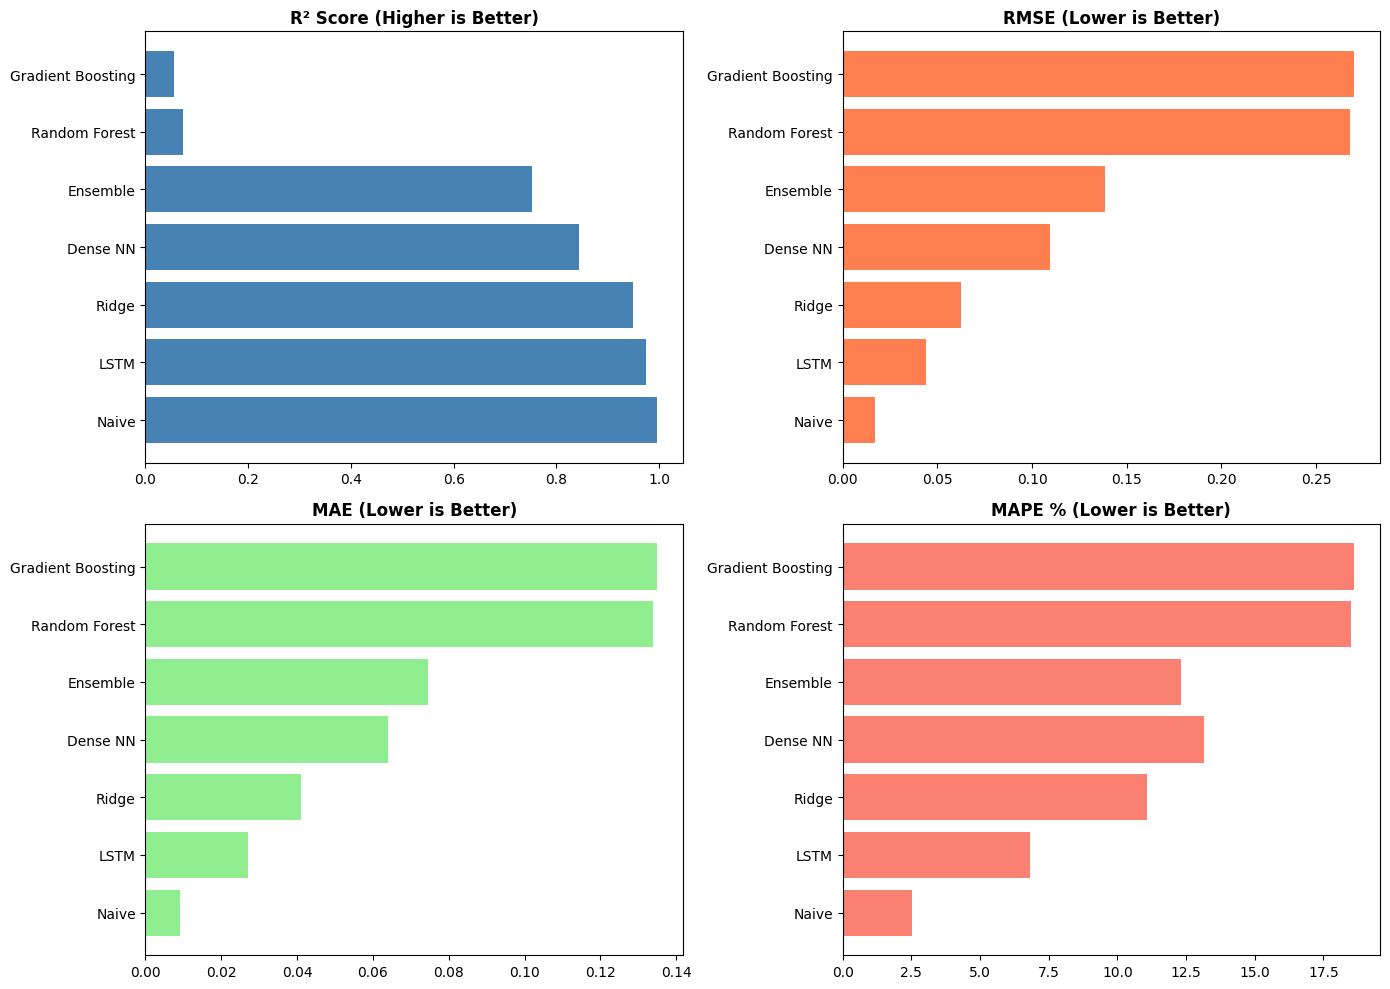

In [12]:
# 1. Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(results_df["Model"], results_df["R²"], color='steelblue')
axes[0, 0].set_title("R² Score (Higher is Better)", fontweight='bold', fontsize=12)
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

axes[0, 1].barh(results_df["Model"], results_df["RMSE"], color='coral')
axes[0, 1].set_title("RMSE (Lower is Better)", fontweight='bold', fontsize=12)

axes[1, 0].barh(results_df["Model"], results_df["MAE"], color='lightgreen')
axes[1, 0].set_title("MAE (Lower is Better)", fontweight='bold', fontsize=12)

axes[1, 1].barh(results_df["Model"], results_df["MAPE"], color='salmon')
axes[1, 1].set_title("MAPE % (Lower is Better)", fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

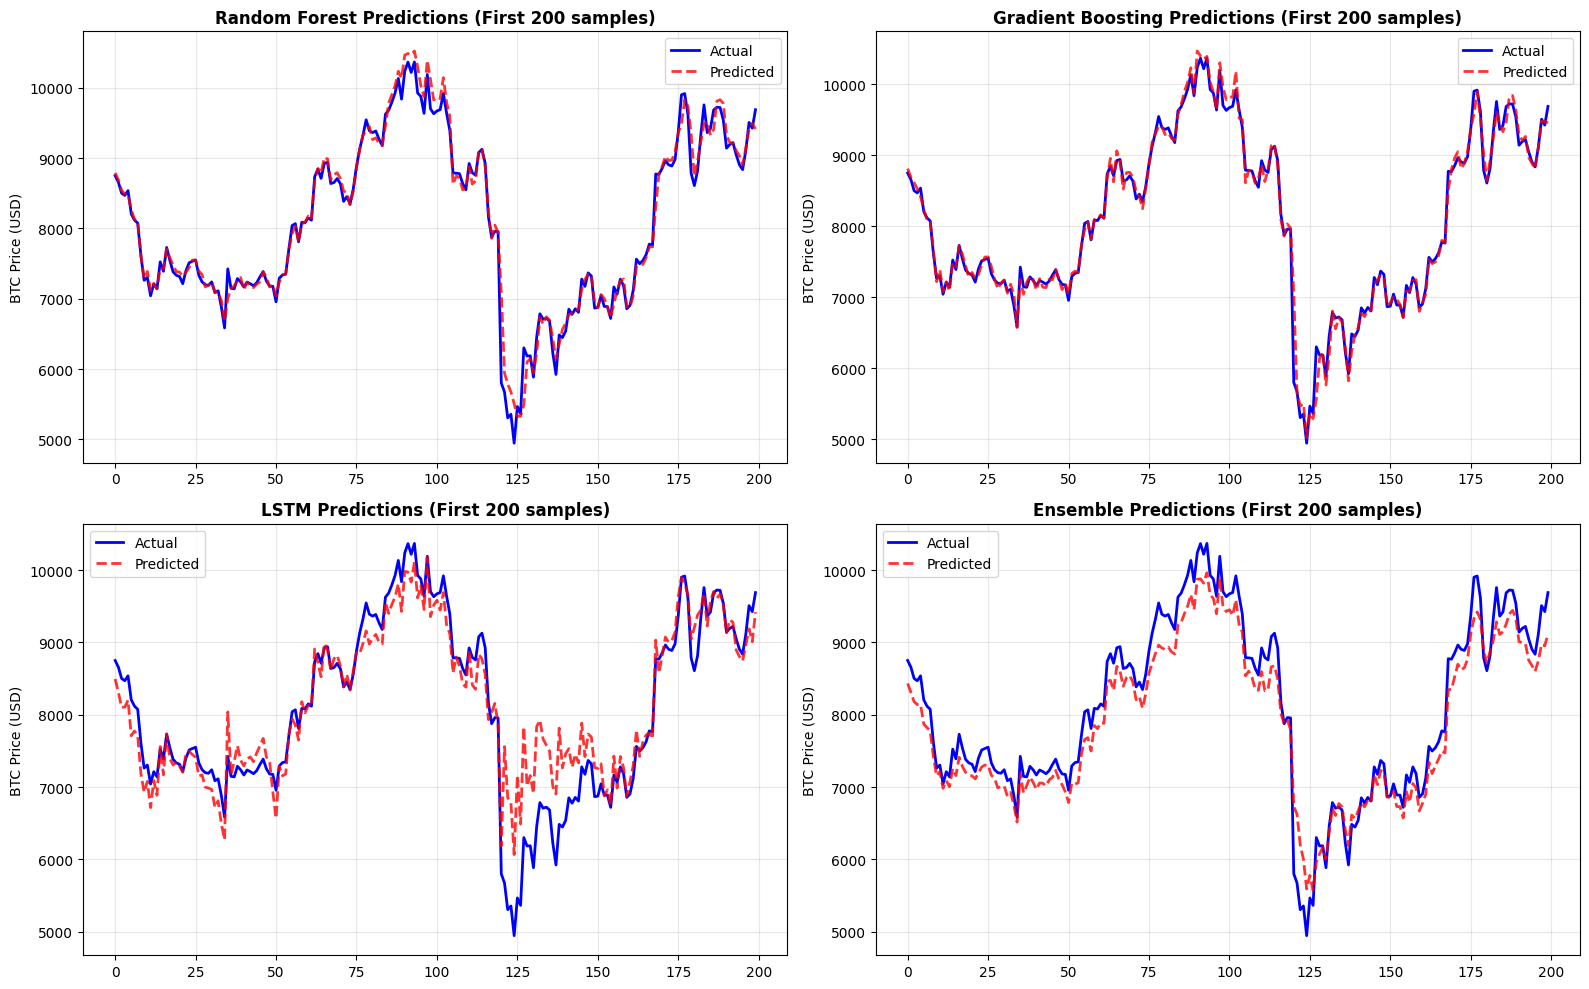

In [13]:
# 2. Predictions vs Actual
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

models_to_plot = [
    ("Random Forest", rf_pred, "steelblue"),
    ("Gradient Boosting", gb_pred, "coral"),
    ("LSTM", lstm_pred, "lightgreen"),
    ("Ensemble", ensemble_pred, "salmon")
]

for idx, (name, pred, color) in enumerate(models_to_plot):
    ax = axes[idx // 2, idx % 2]
    y_pred_orig = scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten()

    ax.plot(range(len(y_test_orig[:200])), y_test_orig[:200], 'b-', label="Actual", linewidth=2)
    ax.plot(range(len(y_pred_orig[:200])), y_pred_orig[:200], 'r--', label="Predicted", linewidth=2, alpha=0.8)
    ax.set_title(f"{name} Predictions (First 200 samples)", fontweight='bold')
    ax.set_ylabel("BTC Price (USD)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

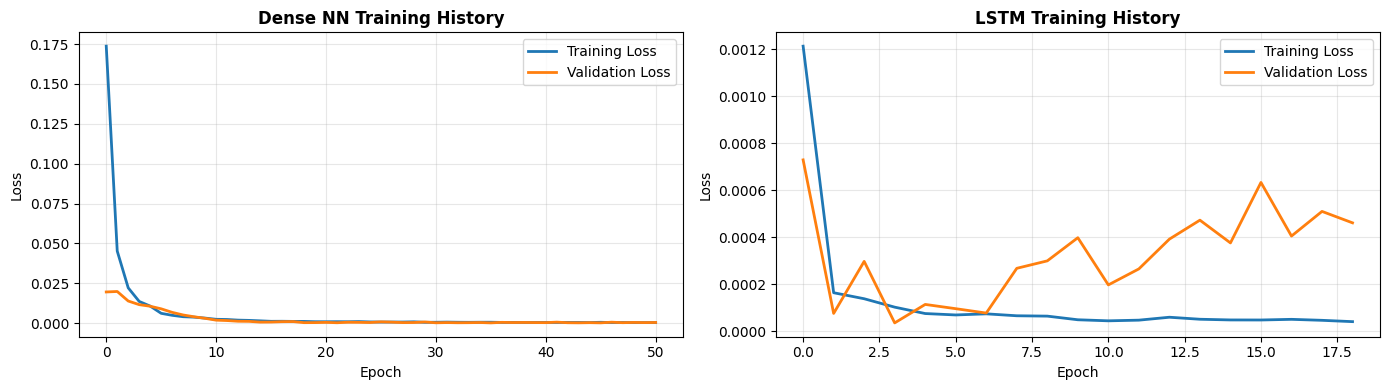

In [14]:

# 3. Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history_dense.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_dense.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title("Dense NN Training History", fontweight='bold')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_lstm.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_lstm.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title("LSTM Training History", fontweight='bold')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

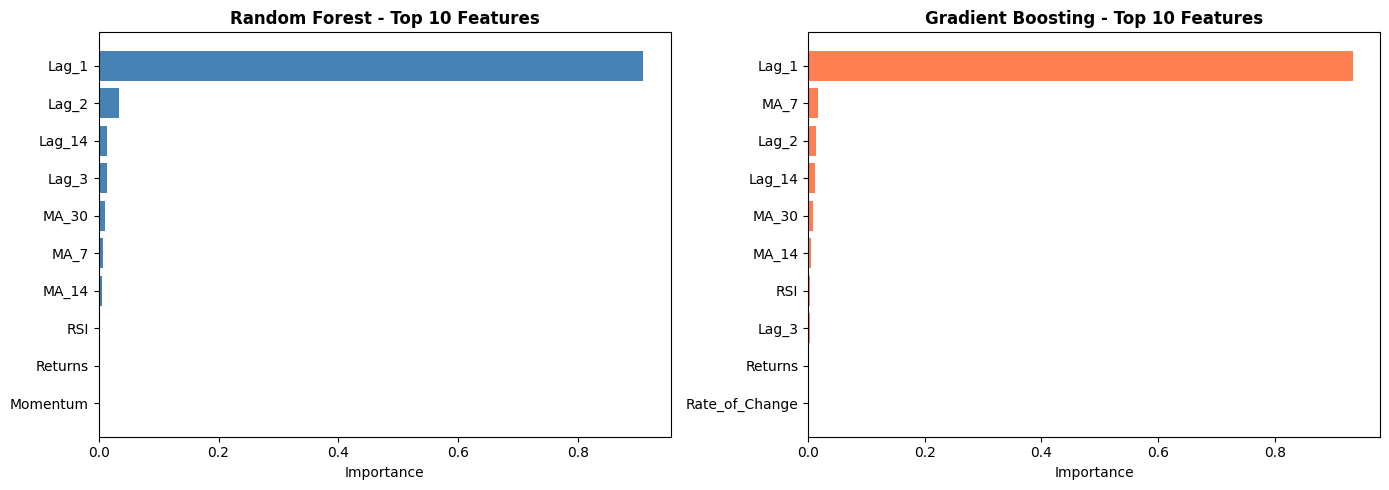

In [15]:
# 4. Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
feature_names = df_features.drop('Price', axis=1).columns
rf_importance = rf.feature_importances_
top_features_rf = np.argsort(rf_importance)[-10:]

axes[0].barh([feature_names[i] for i in top_features_rf], rf_importance[top_features_rf], color='steelblue')
axes[0].set_title("Random Forest - Top 10 Features", fontweight='bold')
axes[0].set_xlabel("Importance")

# Gradient Boosting
gb_importance = gb.feature_importances_
top_features_gb = np.argsort(gb_importance)[-10:]

axes[1].barh([feature_names[i] for i in top_features_gb], gb_importance[top_features_gb], color='coral')
axes[1].set_title("Gradient Boosting - Top 10 Features", fontweight='bold')
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

In [16]:
tscv = TimeSeriesSplit(n_splits=5)
cv_results = []

for name, model in [("Ridge", ridge), ("Random Forest", rf), ("Gradient Boosting", gb)]:
    scores = cross_val_score(model, X_scaled, y_scaled, cv=tscv, scoring='r2', n_jobs=-1)
    cv_results.append({
        "Model": name,
        "Mean R²": scores.mean(),
        "Std Dev": scores.std(),
        "Min": scores.min(),
        "Max": scores.max()
    })

cv_df = pd.DataFrame(cv_results)
print(cv_df.to_string(index=False))

            Model   Mean R²  Std Dev       Min      Max
            Ridge -1.900454 2.783446 -5.664702 0.950811
    Random Forest -0.063910 1.223467 -2.353616 0.992660
Gradient Boosting -0.053630 1.211186 -2.318535 0.991048
